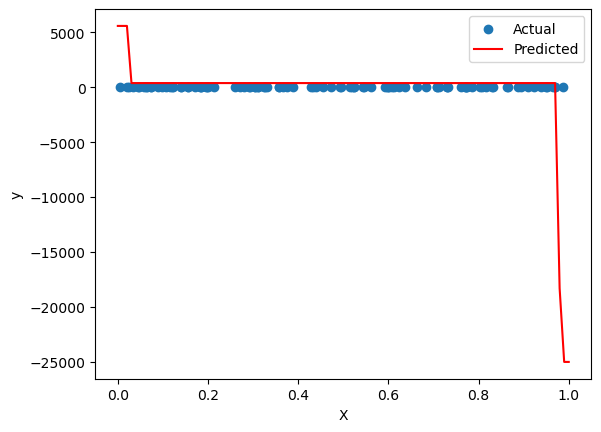

In [1]:
import numpy as np

# Define a simple decision tree class
class DecisionTree:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        if depth == self.max_depth or len(set(y)) == 1:
            return np.mean(y)

        # Find the best split
        best_split = self._find_best_split(X, y)
        if best_split is None:
            return np.mean(y)

        # Recursively build left and right subtrees
        left_indices = best_split['left_indices']
        right_indices = best_split['right_indices']
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {
            'feature_idx': best_split['feature_idx'],
            'threshold': best_split['threshold'],
            'left': left_subtree,
            'right': right_subtree,
        }

    def _find_best_split(self, X, y):
        best_split = None
        best_impurity = float('inf')

        for feature_idx in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_indices = X[:, feature_idx] < threshold
                right_indices = ~left_indices

                if sum(left_indices) == 0 or sum(right_indices) == 0:
                    continue

                left_y = y[left_indices]
                right_y = y[right_indices]

                impurity = self._calculate_impurity(left_y, right_y)
                if impurity < best_impurity:
                    best_impurity = impurity
                    best_split = {
                        'feature_idx': feature_idx,
                        'threshold': threshold,
                        'left_indices': left_indices,
                        'right_indices': right_indices,
                    }

        return best_split

    def _calculate_impurity(self, left_y, right_y):
        # Calculate impurity (e.g., mean squared error for regression)
        return np.mean((left_y - np.mean(left_y)) ** 2) + np.mean((right_y - np.mean(right_y)) ** 2)

    def predict(self, X):
        return np.array([self._predict_single(x, self.tree) for x in X])

    def _predict_single(self, x, tree):
        if isinstance(tree, dict):
            if x[tree['feature_idx']] < tree['threshold']:
                return self._predict_single(x, tree['left'])
            else:
                return self._predict_single(x, tree['right'])
        else:
            return tree

# Implement Gradient Boosting
class GradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.estimators = []

    def fit(self, X, y):
        y_pred = np.mean(y)  # Initialize predictions with the mean of y

        for _ in range(self.n_estimators):
            # Calculate the gradient (negative gradient for MSE)
            gradient = -(y - y_pred)
            # Fit a decision tree to the negative gradient
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X, gradient)
            # Update predictions using the new tree
            y_pred += self.learning_rate * tree.predict(X)
            self.estimators.append(tree)

    def predict(self, X):
        y_pred = np.zeros(len(X))
        for tree in self.estimators:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

# Example usage
if __name__ == "__main__":
    # Generate some synthetic data
    np.random.seed(42)
    X = np.random.rand(100, 1)
    y = 2 * X[:, 0] + np.random.randn(100)

    # Create and fit the Gradient Boosting model
    gb = GradientBoosting(n_estimators=100, learning_rate=0.1, max_depth=3)
    gb.fit(X, y)

    # Make predictions
    X_test = np.linspace(0, 1, 100).reshape(-1, 1)
    y_pred = gb.predict(X_test)

    # Plot the results
    import matplotlib.pyplot as plt

    plt.scatter(X, y, label="Actual")
    plt.plot(X_test, y_pred, label="Predicted", color='red')
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()
    plt.show()


In [3]:
import numpy as np

# Define a simple decision stump as the base learner
class DecisionStump:
    def __init__(self):
        self.threshold = 0.0
        self.feature_idx = 0
        self.alpha = 0.0

    def fit(self, X, y, weights):
        n_samples, n_features = X.shape
        min_error = float('inf')

        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                predictions = np.ones(n_samples)
                predictions[X[:, feature_idx] < threshold] = -1

                error = np.sum(weights[y != predictions])

                if error < min_error:
                    min_error = error
                    self.threshold = threshold
                    self.feature_idx = feature_idx

        self.alpha = 0.5 * np.log((1.0 - min_error) / (min_error + 1e-10))

    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.ones(n_samples)
        predictions[X[:, self.feature_idx] < self.threshold] = -1
        return predictions

# Define the AdaBoost classifier
class AdaBoost:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.alphas = []
        self.models = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        weights = np.ones(n_samples) / n_samples

        for _ in range(self.n_estimators):
            model = DecisionStump()
            model.fit(X, y, weights)
            predictions = model.predict(X)

            weighted_error = np.sum(weights[y != predictions])

            alpha = 0.5 * np.log((1.0 - weighted_error) / (weighted_error + 1e-10))
            weights *= np.exp(-alpha * y * predictions)
            weights /= np.sum(weights)

            self.alphas.append(alpha)
            self.models.append(model)

    def predict(self, X):
        n_samples = X.shape[0]
        final_predictions = np.zeros(n_samples)

        for alpha, model in zip(self.alphas, self.models):
            final_predictions += alpha * model.predict(X)

        return np.sign(final_predictions)

# Example usage
if __name__ == "__main__":
    # Generate synthetic data
    np.random.seed(42)
    X = np.random.rand(100, 2) * 2 - 1
    y = np.sign(X[:, 0] * X[:, 1])

    # Create and train AdaBoost classifier
    ada_boost = AdaBoost(n_estimators=50)
    ada_boost.fit(X, y)

    # Make predictions
    y_pred = ada_boost.predict(X)

    # Calculate accuracy
    accuracy = np.mean(y == y_pred)
    print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.62


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Generate synthetic imbalanced data
X, y = make_classification(n_samples=1000, n_features=20, weights=[0.9, 0.1], random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define class weights
class_weights = {0: 1.0, 1: 10.0}  # Adjust the weights as needed based on the class imbalance

# Decision Tree with Class Weights
tree_classifier = DecisionTreeClassifier(class_weight=class_weights, random_state=42)
tree_classifier.fit(X_train, y_train)
tree_predictions = tree_classifier.predict(X_test)

# Random Forest with Class Weights
rf_classifier = RandomForestClassifier(class_weight=class_weights, random_state=42)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)

# Gradient Boosting with Class Weights
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_classifier.fit(X_train, y_train)
gb_predictions = gb_classifier.predict(X_test)

# XGBoost with Class Weights
xgb_classifier = xgb.XGBClassifier(scale_pos_weight=10.0, random_state=42)
xgb_classifier.fit(X_train, y_train)
xgb_predictions = xgb_classifier.predict(X_test)

# Evaluate the models
def evaluate_model(predictions, model_name):
    accuracy = accuracy_score(y_test, predictions)
    confusion = confusion_matrix(y_test, predictions)
    print(f"{model_name} - Accuracy: {accuracy:.2f}")
    print(f"{model_name} - Confusion Matrix:\n{confusion}")

evaluate_model(tree_predictions, "Decision Tree")
evaluate_model(rf_predictions, "Random Forest")
evaluate_model(gb_predictions, "Gradient Boosting")
evaluate_model(xgb_predictions, "XGBoost")


Decision Tree - Accuracy: 0.90
Decision Tree - Confusion Matrix:
[[257  13]
 [ 18  12]]
Random Forest - Accuracy: 0.93
Random Forest - Confusion Matrix:
[[266   4]
 [ 16  14]]
Gradient Boosting - Accuracy: 0.95
Gradient Boosting - Confusion Matrix:
[[268   2]
 [ 12  18]]
XGBoost - Accuracy: 0.95
XGBoost - Confusion Matrix:
[[267   3]
 [ 12  18]]


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

# Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Base models
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
# Add more base models as needed

# Meta-model (Logistic Regression in this example)
meta_classifier = LogisticRegression()

# Train the base models on the training data
rf_classifier.fit(X_train, y_train)
gb_classifier.fit(X_train, y_train)
knn_classifier.fit(X_train, y_train)
# Train additional base models as needed

# Generate predictions from the base models for the validation set
rf_predictions = rf_classifier.predict(X_test)
gb_predictions = gb_classifier.predict(X_test)
knn_predictions = knn_classifier.predict(X_test)
# Generate predictions from additional base models as needed

# Create a new feature matrix for the meta-model using base model predictions
stacked_predictions = np.column_stack((rf_predictions, gb_predictions, knn_predictions))
# Stack predictions from additional base models as needed

# Train the meta-model on the stacked predictions
meta_classifier.fit(stacked_predictions, y_test)

# Now, make predictions using the base models and the meta-model for stacking
rf_predictions_test = rf_classifier.predict(X_test)
gb_predictions_test = gb_classifier.predict(X_test)
knn_predictions_test = knn_classifier.predict(X_test)
# Generate predictions from additional base models as needed

stacked_test_predictions = np.column_stack((rf_predictions_test, gb_predictions_test, knn_predictions_test))
# Stack predictions from additional base models as needed

meta_predictions = meta_classifier.predict(stacked_test_predictions)

# Evaluate the meta-model's performance
meta_accuracy = accuracy_score(y_test, meta_predictions)
print(f"Meta-Model Accuracy: {meta_accuracy:.2f}")


Meta-Model Accuracy: 0.87


In [3]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Sample data
X = np.array([[1, 2], [2, 3], [3, 4], [5, 6], [6, 7]])
y = np.array([-1, -1, 1, 1, 1])  # Labels (binary classification)

# Initialize sample weights (uniformly distributed)
sample_weights = np.ones(len(X)) / len(X)

# Create an AdaBoostClassifier with DecisionTreeClassifier as the base estimator
n_estimators = 3  # Number of weak classifiers (models)
ada_boost_model = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=n_estimators
)

epsilon = 1e-10  # Small epsilon to avoid division by zero

# Sequentially fit the AdaBoost model and show the weights after each iteration
for i in range(n_estimators):
    print(f"Iteration {i+1}:")
    
    # Fit the AdaBoost model with the current sample weights
    ada_boost_model.fit(X, y, sample_weight=sample_weights)
    
    # Calculate error rate for the current model


Iteration 1:
Iteration 2:
Iteration 3:


C:\Users\unmes\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\unmes\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\unmes\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [4]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Sample data
X = np.array([[1, 2], [2, 3], [3, 4], [5, 6], [6, 7]])
y = np.array([-1, -1, 1, 1, 1])  # Labels (binary classification)

# Initialize sample weights (uniformly distributed)
sample_weights = np.ones(len(X)) / len(X)

# Create an AdaBoostClassifier with DecisionTreeClassifier as the base estimator
n_estimators = 3  # Number of weak classifiers (models)
ada_boost_model = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=n_estimators
)

epsilon = 1e-10  # Small epsilon to avoid division by zero

# Sequentially fit the AdaBoost model and show the weights after each iteration
for i in range(n_estimators):
    print(f"Iteration {i+1}:")
    
    # Fit the AdaBoost model with the current sample weights
    ada_boost_model.fit(X, y, sample_weight=sample_weights)
    
    # Calculate error rate for the current model
    y_pred = ada_boost_model.predict(X)
    misclassified = (y_pred != y)
    error_rate = np.sum(sample_weights * misclassified) / (np.sum(sample_weights) + epsilon)
    
    # Calculate the model weight (alpha)
    alpha = 0.5 * np.log((1 - error_rate) / (error_rate + epsilon))
    
    # Update sample weights and print the indices of increased weights
    for j in range(len(sample_weights)):
        if misclassified[j]:
            sample_weights[j] *= np.exp(alpha + epsilon)  # Increase weight for misclassified points
        else:
            sample_weights[j] *= np.exp(-alpha - epsilon)  # Decrease weight for correctly classified points
    sample_weights /= (np.sum(sample_weights) + epsilon)  # Normalize
    
    print(f"Model {i+1} Weight: {alpha:.4f}")
    print(f"Sample Weights: {sample_weights}")
    print(f"Increased Weights for Misclassified Points: {np.where(misclassified)[0]}\n")

# Final AdaBoost model
final_predictions = ada_boost_model.predict(X)
print("Final Predictions:", final_predictions)


Iteration 1:
Model 1 Weight: 11.5129
Sample Weights: [0.199998 0.199998 0.199998 0.199998 0.199998]
Increased Weights for Misclassified Points: []

Iteration 2:
Model 2 Weight: 11.5129
Sample Weights: [0.199998 0.199998 0.199998 0.199998 0.199998]
Increased Weights for Misclassified Points: []

Iteration 3:
Model 3 Weight: 11.5129
Sample Weights: [0.199998 0.199998 0.199998 0.199998 0.199998]
Increased Weights for Misclassified Points: []

Final Predictions: [-1 -1  1  1  1]


C:\Users\unmes\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\unmes\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\unmes\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [5]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Sample data
X = np.array([[1, 2], [2, 3], [3, 4], [5, 6], [6, 7]])
y = np.array([-1, -1, 1, 1, 1])  # Labels (binary classification)

# Initialize sample weights (uniformly distributed)
sample_weights = np.ones(len(X)) / len(X)

# Create an AdaBoostClassifier with DecisionTreeClassifier as the base estimator
n_estimators = 3  # Number of weak classifiers (models)
ada_boost_model = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=n_estimators
)

epsilon = 1e-10  # Small epsilon to avoid division by zero

# Initialize an array to store predictions of each model in each iteration
model_predictions = []

# Sequentially fit the AdaBoost model and show the weights after each iteration
for i in range(n_estimators):
    print(f"Iteration {i+1}:")
    
    # Fit the AdaBoost model with the current sample weights
    ada_boost_model.fit(X, y, sample_weight=sample_weights)
    
    # Store the predictions of the current model
    model_predictions.append(ada_boost_model.predict(X))
    
    # Calculate error rate for the current model
    y_pred = ada_boost_model.predict(X)
    misclassified = (y_pred != y)
    error_rate = np.sum(sample_weights * misclassified) / (np.sum(sample_weights) + epsilon)
    
    # Calculate the model weight (alpha)
    alpha = 0.5 * np.log((1 - error_rate) / (error_rate + epsilon))
    
    # Update sample weights and print the indices of increased weights
    for j in range(len(sample_weights)):
        if misclassified[j]:
            sample_weights[j] *= np.exp(alpha + epsilon)  # Increase weight for misclassified points
        else:
            sample_weights[j] *= np.exp(-alpha - epsilon)  # Decrease weight for correctly classified points
    sample_weights /= (np.sum(sample_weights) + epsilon)  # Normalize
    
    print(f"Model {i+1} Weight: {alpha:.4f}")
    print(f"Sample Weights: {sample_weights}")
    print(f"Increased Weights for Misclassified Points: {np.where(misclassified)[0]}\n")

# Compute the final prediction based on weighted voting
final_predictions = np.zeros_like(y, dtype=float)
for i, predictions in enumerate(model_predictions):
    alpha = 0.5 * np.log((1 - error_rate) / (error_rate + epsilon))
    final_predictions += alpha * predictions

final_predictions = np.sign(final_predictions)  # Convert to binary predictions (-1 or 1)

print("Final Predictions (Weighted Voting):", final_predictions)


Iteration 1:
Model 1 Weight: 11.5129
Sample Weights: [0.199998 0.199998 0.199998 0.199998 0.199998]
Increased Weights for Misclassified Points: []

Iteration 2:
Model 2 Weight: 11.5129
Sample Weights: [0.199998 0.199998 0.199998 0.199998 0.199998]
Increased Weights for Misclassified Points: []

Iteration 3:
Model 3 Weight: 11.5129
Sample Weights: [0.199998 0.199998 0.199998 0.199998 0.199998]
Increased Weights for Misclassified Points: []

Final Predictions (Weighted Voting): [-1. -1.  1.  1.  1.]


C:\Users\unmes\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\unmes\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\unmes\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [8]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor

# Sample data
X = np.array([[1, 2], [2, 3], [3, 4], [5, 6], [6, 7]])
y = np.array([1, 1, 0, 0, 0])  # Binary labels (0 or 1)

# Initialize ensemble predictions
ensemble_predictions = np.zeros(len(X))

# Create a GradientBoostingClassifier
n_estimators = 3  # Number of boosting stages (models)
learning_rate = 0.1  # Learning rate
gradient_boosting_model = GradientBoostingClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate
)

# Fit the GradientBoostingClassifier and calculate residuals
for i in range(n_estimators):
    print(f"Iteration {i+1}:")
    
    # Calculate residuals (negative gradient)
    residuals = y - 1 / (1 + np.exp(-ensemble_predictions))
    
    # Fit a decision tree regressor to the residuals
    weak_learner = DecisionTreeRegressor(max_depth=1)
    weak_learner.fit(X, residuals)
    
    # Predictions of the weak learner
    weak_predictions = weak_learner.predict(X)
    
    # Update the ensemble predictions with weighted weak predictions
    ensemble_predictions += learning_rate * weak_predictions
    
    print(f"Residuals: {residuals}")
    print(f"Weak Learner Predictions: {weak_predictions}")
    print(f"Updated Ensemble Predictions: {ensemble_predictions}\n")

# Final Ensemble Predictions
final_predictions = 1 / (1 + np.exp(-ensemble_predictions))  # Convert to probabilities
print("Final Ensemble Predictions (Probabilities):", final_predictions)


Iteration 1:
Residuals: [ 0.5  0.5 -0.5 -0.5 -0.5]
Weak Learner Predictions: [ 0.5  0.5 -0.5 -0.5 -0.5]
Updated Ensemble Predictions: [ 0.05  0.05 -0.05 -0.05 -0.05]

Iteration 2:
Residuals: [ 0.4875026  0.4875026 -0.4875026 -0.4875026 -0.4875026]
Weak Learner Predictions: [ 0.4875026  0.4875026 -0.4875026 -0.4875026 -0.4875026]
Updated Ensemble Predictions: [ 0.09875026  0.09875026 -0.09875026 -0.09875026 -0.09875026]

Iteration 3:
Residuals: [ 0.47533248  0.47533248 -0.47533248 -0.47533248 -0.47533248]
Weak Learner Predictions: [ 0.47533248  0.47533248 -0.47533248 -0.47533248 -0.47533248]
Updated Ensemble Predictions: [ 0.14628351  0.14628351 -0.14628351 -0.14628351 -0.14628351]

Final Ensemble Predictions (Probabilities): [0.5365058 0.5365058 0.4634942 0.4634942 0.4634942]


In [9]:
import statsmodels.api as sm
import numpy as np

# Generate some synthetic data for binary classification
np.random.seed(0)
X = np.random.randn(100, 2)
y = (X[:, 0] + X[:, 1] > 0).astype(int)  # Create a binary target variable

# Add a constant term (intercept) to the features
X = sm.add_constant(X)

# Fit a logistic regression model
logit_model = sm.Logit(y, X)

# Perform the logistic regression
logit_result = logit_model.fit()

# Print the summary of the logistic regression model
print(logit_result.summary())


C:\Users\unmes\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\unmes\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\unmes\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations 32


LinAlgError: Singular matrix